In [1]:
#Instal
!pip install yfinance --upgrade --no-cache-dir
# virtualenv -p python3 virtualenvironment
# source virtualenvironment/bin/activate
!pip install ta --upgrade --no-cache-dir
!pip install pandas_ta --upgrade --no-cache-dir
#imports
import time
import sys
from math import floor
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import yfinance as yf
import pandas_datareader as web
import matplotlib.pyplot as plt

from ta.volatility import bollinger_mavg, KeltnerChannel

yf.pdr_override()

In [2]:
#Define functions

#GET YAHOO DATA
def get_data(ticker):    
    ticker_data = web.get_data_yahoo(ticker, START_DATE, END_DATE)
    return ticker_data

def convert_data(ticker_data, ticker):
    
    names = []
    table = []
    
    ticker_data = ticker_data.rename(columns = {ticker:'Close'})
    for i in range(0, LOOP_MAX, SHIFT_DAYS) :
        data = ticker_data[i:CORR_WINDOW + i]
        date = data.index[0]
        ticker_name = ticker + ' ' + date.strftime('%Y/%m/%d')
        names.append(ticker_name)
        data['Ticker'] = ticker_name
        table.append(data)    
        
    return [names, table]

#CREATE DATAFRAMES
def create_dfs(datas_to_df):
    dfs = []
    for data_to_df in datas_to_df :
        name, data = data_to_df
        df = pd.DataFrame()
        df = pd.concat(data)
        df = df.reset_index()
        df = df.pivot(columns='Ticker',values='Close')
        dfs.append(df)
    return dfs

#PIVOT FUNCTIONS
def pivot_df(df_pivot, data, names): 
    for i in range(floor(LOOP_MAX/SHIFT_DAYS)) :
        column_name = names[i]
        values = data[column_name].values
        values = values[~np.isnan(values)]
        values = pd.Series(values)
        df_pivot.insert(len(df_pivot.columns), column_name, values)
        
    return df_pivot

def pivot_all_dfs(dfs, datas):
    dfs_pivoted = []
    names = []
    loop_times = len(dfs) - 1
    
    for j in range(loop_times):
        for i in range(j, loop_times):
            name_to_first = datas[j][0]
            names_to_second = datas[i + 1][0]
            names.append([name_to_first, names_to_second])
            
            df_pivoted = pd.DataFrame()
            df_pivoted = pivot_df(df_pivoted, dfs[j], name_to_first)
            df_pivoted = pivot_df(df_pivoted, dfs[i + 1], names_to_second)
            dfs_pivoted.append(df_pivoted)
        
    return [dfs_pivoted, names]

#CORRELATION FUNCTIONS
def get_corr_df(df_pivot, nameRow, nameColumn):
    #Using corr function to get correlation between actives
    corr_df = df_pivot.corr(method='pearson')
    #reset symbol as index (rather than 0-X)
    corr_df.head().reset_index()
    corr_df = corr_df.rename_axis(None, axis=0)
    corr_df = corr_df.drop(nameRow, axis=1)
    corr_df = corr_df.drop(nameColumn, axis=0)
    
    return corr_df

def get_all_corr_dfs(dfs, names):
    dfs_corr = []
    for i in range(len(dfs)):
        corr_df = get_corr_df(dfs[i], names[i][0], names[i][1])
        dfs_corr.append(corr_df)
    
    return dfs_corr

#INDICATOR FUNCTIONS
def get_indicators(df):
    values = df.values
    means_df = pd.DataFrame()
    deviations_df = pd.DataFrame()
    columns_name = []
    rang = floor(LOOP_MAX/2)
    for i in range(rang):
        means = []
        deviations = []
        row_name = df.index[i] + " - " + df.index[i + CORR_WINDOW].split(' ')[1] 
        for j in range(rang):
            if i == 0:
                column_name = df.columns[j] + " - " + df.columns[j + CORR_WINDOW].split(' ')[1] 
                columns_name.append(column_name)
            ax = []
            for k in range(CORR_WINDOW):
                value = values[i+k][j+k]
                ax.append(value)

            mean = np.average(ax)
            means.append(mean)

            deviation = np.std(ax)
            deviations.append(deviation)
            
        aux_df = pd.DataFrame([means], columns=columns_name, index=[row_name])
        means_df = pd.concat([means_df, aux_df])
        aux_df = pd.DataFrame([deviations], columns=columns_name, index=[row_name])
        deviations_df = pd.concat([deviations_df, aux_df])
        
    return [means_df, deviations_df]

def get_df_plot(dfs_corr):
    means, deviations = get_indicators(dfs_corr)
    
    rang = len(means.index) - SHIFT_DAYS
    values_means = means.values
    values_deviations = deviations.values
    values = []
    columns = [1,2,3,4]
    
    for i in range(rang):
        value = []
        value_mean = values_means[i][i + SHIFT_DAYS]
        value_deviation = values_deviations[i][i + SHIFT_DAYS]
        value.append(value_mean)
        value.append(value_deviation)
        
        value_mean = values_means[i + SHIFT_DAYS][i]
        value_deviation = values_deviations[i + SHIFT_DAYS][i]
        value.append(value_mean)
        value.append(value_deviation)
        
        values.append(value)
    columns = get_columns_name(means)    
    final_df = pd.DataFrame(values, columns=columns)
    return final_df

def get_columns_name(df):
    names = []
    
    for ind in ["Means", "Deviations"]:
        ticker = df.columns[0].split(" ")[0]
        
        index = df.index[0].split(" ")
        start_date = index[1]

        last_index = df.index[len(df.index) - (SHIFT_DAYS + 1)].split(" ") 
        end_date = last_index[1]
        name = ind + " - "
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date + "\n"

        index = df.index[1].split(" ")
        last_index = df.index[-1].split(" ")
        start_date = index[1]
        end_date = last_index[1]
        ticker = index[0]
        
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date
        names.append(name)
        
    for ind in ["Means", "Deviations"]:
        index = df.index[0].split(" ")
        start_date = index[1]
        ticker = index[0]
        last_index = df.index[len(df.index) - (SHIFT_DAYS + 1)].split(" ") 
        end_date = last_index[1]
        
        name = ind + " - "
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date + "\n"

        index = df.index[1].split(" ")
        last_index = df.index[-1].split(" ")
        start_date = index[1]
        end_date = last_index[1]
        ticker = df.columns[0].split(" ")[0]
        
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date
        names.append(name)
        
    return names

def get_price_df(df_p, names):
    df = pd.DataFrame()
    dates = []
    length = len(df_p[names[0]].columns)
    
    column = []    
    ticker = names[0][0].split(" ")[0]
    for i in range(length):
        dates.append(names[0][i].split(" ")[1])
        column.append(df_p[names[0]].values[0][i])
    
    df.insert(len(df.columns), ticker, column)
    
    column = []
    ticker = names[1][0].split(" ")[0]
    for i in range(length):
        column.append(df_p[names[1]].values[0][i])
            
    df.insert(len(df.columns), ticker, column) 
    
    mavg = get_mavg(df)
    df = df.join(mavg)
    df.insert(0, "Date", dates)
    return df

def get_mavg(df):
    mavg_df = pd.DataFrame()
    
    for column in df.columns:
        mavg_aux = bollinger_mavg(df[column], window=MAVG_WINDOW, fillna=True)
        mavg_df.insert(len(mavg_df.columns),"moving average of " + column, mavg_aux)
        
    return mavg_df

#Keltner Channel
def get_KC(data, ticker):    
    high = list(data["High"][ticker])
    close = list(data["Close"][ticker])
    low = list(data["Low"][ticker])
#     lenght = len(datas[1])
#     data = datas[1]

#     for i in range(lenght):
#         high.append(data[i]["High"][0])
#         close.append(data[i]["Close"][0])
#         low.append(data[i]["Low"][0])

    df_o = pd.DataFrame({"High": high, "Close": close, "Low": low})
    
    KC = KeltnerChannel(high=df_o["High"], close=df_o["Close"], low=df_o["Low"], multiplier=MULTIPLIER, window=20, fillna=True)
    
    return KC

def get_all_stocks_KC(data):
    lenght = len(data["High"].columns)
    dfs = []
    for i in range(lenght):
        ticker1 = tickers[i]
        df_kc1 = get_KC(data, ticker1)
        high1 = list(df_kc1.keltner_channel_hband())
        low1 = list(df_kc1.keltner_channel_lband())
        
        for j in range(i+1, lenght):
            ticker2 = tickers[j]
            df_kc2 = get_KC(data, ticker2)
            high2 = list(df_kc2.keltner_channel_hband())
            low2 = list(df_kc2.keltner_channel_lband())
            
            df_aux = pd.DataFrame({ticker1 + "-High": high1, ticker1 + "-Low": low1, 
                                   ticker2 + "-High": high2, ticker2 + "-Low": low2})
            dfs.append(df_aux)
            
    return dfs

In [3]:
def trade_comprado(corr_df, price_df, kcs_df, predict_stock):
    equity = pd.DataFrame(columns=['Date', 'Profit'])
    
#     lost_corr = ENTER_CORR - 0.1
    enter_corr = ENTER_CORR
    
#     stop_lose = 0.06
    
    price_length = len(price_df.index)
    corr_length = len(corr_df.index)
    corr_relation = floor(price_length / corr_length)
    
    date = price_df.columns[0]
    dates = price_df[date]
    
    if(predict_stock == 1):
        stock_a = price_df.columns[1]
        stock_b = price_df.columns[2]
        stock_a_mavg = price_df.columns[3]
        stock_b_mavg = price_df.columns[4]

        stock_a_predicting_mean_corr = corr_df.columns[0]
        stock_a_predicting_desviation_corr = corr_df.columns[1]
        stock_b_predicting_mean_corr = corr_df.columns[2]
        stock_b_predicting_desviation_corr = corr_df.columns[3]

        stock_a_high_kc = kcs_df.columns[0]
        stock_a_low_kc = kcs_df.columns[1]
        stock_b_high_kc = kcs_df.columns[2]
        stock_b_low_kc = kcs_df.columns[3]
    
    else:
        stock_a = price_df.columns[2]
        stock_b = price_df.columns[1]
        stock_a_mavg = price_df.columns[4]
        stock_b_mavg = price_df.columns[3]

        stock_a_predicting_mean_corr = corr_df.columns[2]
        stock_a_predicting_desviation_corr = corr_df.columns[3]
        stock_b_predicting_mean_corr = corr_df.columns[0]
        stock_b_predicting_desviation_corr = corr_df.columns[1]

        stock_a_high_kc = kcs_df.columns[2]
        stock_a_low_kc = kcs_df.columns[3]
        stock_b_high_kc = kcs_df.columns[0]
        stock_b_low_kc = kcs_df.columns[1]
        
    file = open(path_comprado, "a+")
            
    nmb_stock = 0
    nmb_orders = 0
    paid_stock = 0
    money = 1000
    sell_cause = ""
    bought = False

    title = "Using {0} to predict {1}\n".format(stock_a, stock_b)
    file.write(title)

    for i in range(price_length):
        stock_price = price_df[stock_b][i]

        aux = floor(i / corr_relation)
        if aux >= corr_length:
            aux = corr_length - 1

        if bought:
            if stock_price > kcs_df[stock_b_high_kc][i]:
                sell_cause = "Better than KC"
                bought = False
            if price_df[stock_a][i] < price_df[stock_a_mavg][i]:
                sell_cause = "{0} is low than mavg".format(stock_a)
                bought = False
#                 if corr_df[stock_b_predicting_mean_corr][aux] < lost_corr:#testar sem este IF
#                     sell_cause = "Lost correlation"
#                     bought = False
#                 if stock_price <= paid_stock * (1 - stop_lose):
#                     sell_cause = "Stop, lost {0}%".format(stop_lose * 100)
#                     bought = False

            if not bought:
                if(nmb_stock > 0):
                    profit = ((stock_price * nmb_stock) - (paid_stock * nmb_stock))
                    EC_aux = pd.DataFrame([{"Date": dates[i], "Profit": profit}])
                    equity = equity.append(EC_aux)
                money += stock_price * nmb_stock
                nmb_stock = 0
                file.write("selling in {0} - money: {1} - cause:{2}\n".format(dates[i], money, sell_cause))#stonk prices
                nmb_orders += 1
        else:
            if price_df[stock_a][i] > price_df[stock_a_mavg][i]:
                if stock_price < price_df[stock_b_mavg][i]:
                    if corr_df[stock_b_predicting_mean_corr][aux] > enter_corr:
                        bought = True
                        nmb_stock = floor(money/stock_price)
                        money = money%stock_price
                        paid_stock = stock_price
                        file.write("buying in {0} - money: {1}, stocks: {2}\n".format(dates[i], money, nmb_stock))
                        nmb_orders += 1
    file.write("Money in final of tests {0} and Number of orders {1}\n\n".format(money, nmb_orders))
    
    file.close()
 
    return [equity, nmb_orders]

def trade_vendido(corr_df, price_df, kcs_df, predict_stock):
    equity = pd.DataFrame(columns=['Date', 'Profit'])
    
#     lost_corr = ENTER_CORR - 0.1
    enter_corr = ENTER_CORR
    
#     stop_lose = 0.06
    
    price_length = len(price_df.index)
    corr_length = len(corr_df.index)
    corr_relation = floor(price_length / corr_length)
    
    date = price_df.columns[0]
    dates = price_df[date]
    
    if(predict_stock == 1):
        stock_a = price_df.columns[1]
        stock_b = price_df.columns[2]
        stock_a_mavg = price_df.columns[3]
        stock_b_mavg = price_df.columns[4]

        stock_a_predicting_mean_corr = corr_df.columns[0]
        stock_a_predicting_desviation_corr = corr_df.columns[1]
        stock_b_predicting_mean_corr = corr_df.columns[2]
        stock_b_predicting_desviation_corr = corr_df.columns[3]

        stock_a_high_kc = kcs_df.columns[0]
        stock_a_low_kc = kcs_df.columns[1]
        stock_b_high_kc = kcs_df.columns[2]
        stock_b_low_kc = kcs_df.columns[3]
    
    else:
        stock_a = price_df.columns[2]
        stock_b = price_df.columns[1]
        stock_a_mavg = price_df.columns[4]
        stock_b_mavg = price_df.columns[3]
        
        stock_a_predicting_mean_corr = corr_df.columns[2]
        stock_a_predicting_desviation_corr = corr_df.columns[3]
        stock_b_predicting_mean_corr = corr_df.columns[0]
        stock_b_predicting_desviation_corr = corr_df.columns[1]
        
        stock_a_high_kc = kcs_df.columns[2]
        stock_a_low_kc = kcs_df.columns[3]
        stock_b_high_kc = kcs_df.columns[0]
        stock_b_low_kc = kcs_df.columns[1]
        
    file = open(path_vendido, "a+")
    
    nmb_stock = 0
    nmb_orders = 0
    sold_stock = 0
    money = 1000
    purchase_cause = ""
    sold = True

    title = "Using {0} to predict {1}\n".format(stock_a, stock_b)
    file.write(title)

    for i in range(price_length):
        stock_price = price_df[stock_b][i]

        aux = floor(i / corr_relation)
        if aux >= corr_length:
            aux = corr_length - 1

        if sold:
            if stock_price < kcs_df[stock_b_low_kc][i]:
                purchase_cause = "Lower than KC"
                sold = False
            if price_df[stock_a][i] > price_df[stock_a_mavg][i]:
                purchase_cause = "{0} is better than mavg".format(stock_a)
                sold = False
#                 if corr_df[stock_b_predicting_mean_corr][aux] < lost_corr:#testar sem este IF
#                     purchase_cause = "Lost correlation"
#                     sold = False
#                 if stock_price >= sold_stock * (1 - stop_lose):
#                     purchase_cause = "Stop, lost {0}%".format(stop_lose * 100)
#                     sold = False

            if not sold:
                nmb_stock = floor(money/stock_price)
                money = money%stock_price
                if(sold_stock != 0):
                    profit = ((sold_stock * nmb_stock) - (stock_price * nmb_stock))
                    EC_aux = pd.DataFrame([{"Date": dates[i], "Profit": profit}])
                    equity = equity.append(EC_aux)
                file.write("Buying in {0} - money: {1},  stocks: {2} - cause:{3}\n".format(dates[i], money, nmb_stock, purchase_cause))
                nmb_orders += 1

        else:
            if price_df[stock_a][i] < price_df[stock_a_mavg][i]:
                if stock_price > price_df[stock_b_mavg][i]:
                    if corr_df[stock_b_predicting_mean_corr][aux] > enter_corr:
                        sold = True
                        money += stock_price * nmb_stock
                        nmb_stock = 0
                        sold_stock = stock_price
                        file.write("Selling in {0} - money: {1}\n".format(dates[i], money))
                        nmb_orders += 1

    file.write("Money in final of tests {0} and Number of orders {1}\n\n".format(money, nmb_orders))
        
    file.close()
    return [equity, nmb_orders]

In [4]:
#Constants
#Fazer mais simulações
SHIFT_DAYS = 1
CORR_WINDOW = 9 # 5,7,9
MAVG_WINDOW = 42 # 36,38,40,42
MULTIPLIER = 1 # 1,2,3
ENTER_CORR = 0.7

START_DATE = datetime(2019, 1, 1)
END_DATE = datetime(2021, 1, 1)

In [5]:
#Load data
tickers = ['ENBR3.SA','VALE3.SA','ITUB3.SA','BBAS3.SA','BBSE3.SA', 'PSSA3.SA']
len_tickers = len(tickers)
range_len_tickers = range(len_tickers)

loaded_datas = get_data(tickers)

LOOP_MAX = len(loaded_datas) - CORR_WINDOW - SHIFT_DAYS

path_comprado = "trade_comprado.txt"
path_vendido = "trade_vendido.txt"

In [7]:
def new_parameters(profit, key, nmb_orders):
    new_parameters = parameters[key]
    
    new_parameters['PROFIT'] = profit
    new_parameters['CORR_WINDOW'] = int(CORR_WINDOW)
    new_parameters['MAVG_WINDOW'] = int(MAVG_WINDOW)
    new_parameters['MULTIPLIER'] = int(MULTIPLIER)
    new_parameters['ENTER_CORR'] = ENTER_CORR 
    new_parameters['ORDERS'] = int(nmb_orders)
    
    parameters[key] = new_parameters
    return

parameters = {}
for i in range_len_tickers:
    for j in range(i+1, len_tickers, 1):
        key = 'Using {0} to predict {1}'.format(tickers[j].split('.')[0],tickers[i].split('.')[0])
        parameters[key] = {'PROFIT': -sys.maxsize, 'CORR_WINDOW': 0, 'MAVG_WINDOW': 0, 'MULTIPLIER': 0, 'ENTER_CORR': 0, 'ORDERS': 0}
        key = 'Using {0} to predict {1}'.format(tickers[i].split('.')[0],tickers[j].split('.')[0])
        parameters[key] = {'PROFIT': -sys.maxsize, 'CORR_WINDOW': 0, 'MAVG_WINDOW': 0, 'MULTIPLIER': 0, 'ENTER_CORR': 0, 'ORDERS': 0}

for corr_window in [5,7,9]:
    CORR_WINDOW = corr_window
    LOOP_MAX = len(loaded_datas) - CORR_WINDOW - SHIFT_DAYS

    all_data = []
    for ticker in tickers:
        data = convert_data(pd.DataFrame(loaded_datas["Close"][ticker]), ticker)
        all_data.append(data)
    
    dfs = create_dfs(all_data)
        
    dfs_pivoted, names = pivot_all_dfs(dfs, all_data)

    dfs_corr = get_all_corr_dfs(dfs_pivoted, names)
    
    len_dfs_corr = len(dfs_corr)
    range_len_dfs_corr = range(len_dfs_corr)
    
    indicators_dfs = []
    for i in range_len_dfs_corr:
        aux_ind = get_df_plot(dfs_corr[i])
        indicators_dfs.append(aux_ind)
        
    for mavg_window in [36,38,40,42]:
        MAVG_WINDOW = mavg_window
        
        prices_dfs = []
        for i in range_len_dfs_corr:
            price_df = get_price_df(dfs_pivoted[i], names[i])
            prices_dfs.append(price_df )
            
        for multiplier in [1,2,3]:
            MULTIPLIER = multiplier
            
            dfs_kc = get_all_stocks_KC(loaded_datas)
            
            for enter_corr in [0.64,0.66,0.68,0.7,0.72]:
                ENTER_CORR = enter_corr
                
                for i in range_len_dfs_corr:
                    for number in [1,0]:
                        
                        equity_curve = pd.DataFrame(columns=['Date', 'Profit'])
                        
                        if number == 0:
                            key = list(parameters.keys())[(i * 2) + 1]
                        else:
                            key = list(parameters.keys())[(i * 2)]
                            
                        equity_aux, nmbs = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i], number)
                        nmb_orders = nmbs
                        equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
                        equity_aux, nmbs = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i], number)
                        nmb_orders += nmbs
                        equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)

                        equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
                        list_equity_curve = list(equity_curve['Profit'].values)
                        final_profit = list_equity_curve[-1] if len(list_equity_curve) > 0 else 0

                        if(final_profit > parameters[key]['PROFIT']):
                            new_parameters(final_profit, key, nmb_orders)

C:\Users\turen\AppData\Local\Temp/ipykernel_11552/1492329741.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker_name
C:\Users\turen\AppData\Local\Temp/ipykernel_11552/3160435079.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs_pivoted, names = pivot_all_dfs(dfs, all_data)


In [13]:
pd.DataFrame(parameters).values[0].sum()
pd.DataFrame(parameters).to_excel("out.xlsx")

In [6]:
pd.DataFrame(parameters)

Attributes  Adj Close                                                         \
Symbols      ENBR3.SA   VALE3.SA   ITUB3.SA   BBAS3.SA   BBSE3.SA   PSSA3.SA   
Date                                                                           
2019-01-02  11.795794  37.180229  27.625319  38.857906  21.315542  20.823477   
2019-01-03  12.286592  35.659248  27.875986  39.017803  21.548870  20.162859   
2019-01-04  12.378097  37.980743  27.409218  39.017803  21.338120  19.306059   
2019-01-07  12.020394  37.776974  27.763617  38.761959  21.022001  19.694420   
2019-01-08  12.061991  38.140846  27.832767  38.322205  20.713408  20.178877   
...               ...        ...        ...        ...        ...        ...   
2020-12-22  16.781324  67.661163  25.950762  33.929218  25.995554  20.937016   
2020-12-23  16.807129  67.988029  26.345953  34.487469  25.968811  21.041613   
2020-12-28  17.056568  67.949112  26.750555  34.868496  26.503698  21.577677   
2020-12-29  17.056568  67.762337  26.647055  34.664684  26.797888  21.590754   
2020-12-30  16.901743  68.058067  26.280087  34.381138  26.414551  21.355408   

Attributes      Close                                   ...       Open  \
Symbols      ENBR3.SA   VALE3.SA   ITUB3.SA   BBAS3.SA  ...   ITUB3.SA   
Date                                                    ...              
2019-01-02  14.180000  51.090000  31.959999  48.599998  ...  30.049999   
2019-01-03  14.770000  49.000000  32.250000  48.799999  ...  31.309999   
2019-01-04  14.880000  52.189999  31.709999  48.799999  ...  32.250000   
2019-01-07  14.450000  51.910000  32.119999  48.480000  ...  31.950001   
2019-01-08  14.500000  52.410000  32.200001  47.930000  ...  32.119999   
...               ...        ...        ...        ...  ...        ...   
2020-12-22  19.510000  86.940002  27.580000  38.290001  ...  27.490000   
2020-12-23  19.540001  87.360001  28.000000  38.919998  ...  27.629999   
2020-12-28  19.830000  87.309998  28.430000  39.349998  ...  28.170000   
2020-12-29  19.830000  87.070000  28.320000  39.119999  ...  28.410000   
2020-12-30  19.650000  87.449997  27.930000  38.799999  ...  28.389999   

Attributes                                      Volume                        \
Symbols      BBAS3.SA   BBSE3.SA   PSSA3.SA   ENBR3.SA    VALE3.SA  ITUB3.SA   
Date                                                                           
2019-01-02  46.200001  27.879999  25.850000  2320100.0  17319600.0  976900.0   
2019-01-03  48.500000  28.350000  25.730000  3951300.0  30120000.0  283000.0   
2019-01-04  48.080002  28.459999  25.055000  2418400.0  43360100.0  336400.0   
2019-01-07  48.830002  28.500000  24.125000  3090200.0  20998900.0  222800.0   
2019-01-08  48.599998  27.930000  24.885000  3100400.0  19925600.0  266600.0   
...               ...        ...        ...        ...         ...       ...   
2020-12-22  38.139999  29.030001  24.084999  1449400.0  23157000.0  363200.0   
2020-12-23  38.570000  29.240000  24.000000  1265900.0  17710200.0  598700.0   
2020-12-28  39.320000  29.290001  24.245001  1616500.0  26001300.0  775800.0   
2020-12-29  39.500000  29.889999  24.850000  1960700.0  19727500.0  266100.0   
2020-12-30  39.279999  30.200001  24.809999  4501700.0  30102700.0  800800.0   

Attributes                                    
Symbols       BBAS3.SA   BBSE3.SA   PSSA3.SA  
Date                                          
2019-01-02  14905300.0  4663200.0   960800.0  
2019-01-03   8879100.0  3517600.0  1287200.0  
2019-01-04   8859200.0  3549900.0  2483000.0  
2019-01-07   9393500.0  3467500.0  1271800.0  
2019-01-08  14517300.0  4137700.0  1973600.0  
...                ...        ...        ...  
2020-12-22  10770400.0  2011100.0  1064800.0  
2020-12-23   9176300.0  2086500.0  1477200.0  
2020-12-28   7577200.0  2205000.0  1426800.0  
2020-12-29   7301400.0  2704700.0  1397600.0  
2020-12-30   8594000.0  3015900.0  1608000.0  

[496 rows x 36 columns]

In [13]:
all_data = []

for ticker in tickers:
    data = convert_data(pd.DataFrame(loaded_datas["Close"][ticker]), ticker)
    all_data.append(data)

dfs = create_dfs(all_data)
    
#Pivoting table to aggregate active price in a line of each date
dfs_pivoted, names = pivot_all_dfs(dfs, all_data)

dfs_corr = get_all_corr_dfs(dfs_pivoted, names)

len_dfs_corr = len(dfs_corr)
range_len_dfs_corr = range(len_dfs_corr)

3771.38956451416

In [142]:
# fig, corr_ax = plt.subplots()
indicators_dfs = []
prices_dfs = []

for i in range_len_dfs_corr:
    aux_ind = get_df_plot(dfs_corr[i])
    indicators_dfs.append(aux_ind)
    
    price_df = get_price_df(dfs_pivoted[i], names[i])
    prices_dfs.append(price_df)

# for i in range(2): 
#     mean = final_df.columns[i * 2]
#     deviation = final_df.columns[(i * 2) + 1]
#     plt.fill_between(final_df.index, final_df[mean] - final_df[deviation], final_df[mean] + final_df[deviation], alpha=0.2)
#     final_df.plot(y=mean,figsize=(10,10), xlim=[0, len(final_df[mean]) - 1], ylim=[-1,1], grid=True, ax=corr_ax)

KeyboardInterrupt: 

In [124]:
dfs_kc = get_all_stocks_KC(loaded_datas)

# fig, price_ax = plt.subplots()

# price_df.plot(figsize=(10,10), xlim=[0, len(price_df) - 1], grid=True, ax=price_ax)

In [126]:
#Testes

# equity_curve = pd.DataFrame(data=[{"Date": "2021/07/11", "Profit": -10},{"Date": "2022/05/12", "Profit": 50}, {"Date": "2020/06/11", "Profit": 20}],columns=['Date', 'Profit'])
# EC_aux = pd.DataFrame([{"Date": "2022/06/11", "Profit": -15}])
# equity_curve = pd.concat([equity_curve, EC_aux])
# equity_curve.sort_values(by='Date')
# equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
# equity_curve

<AxesSubplot:xlabel='Date'>

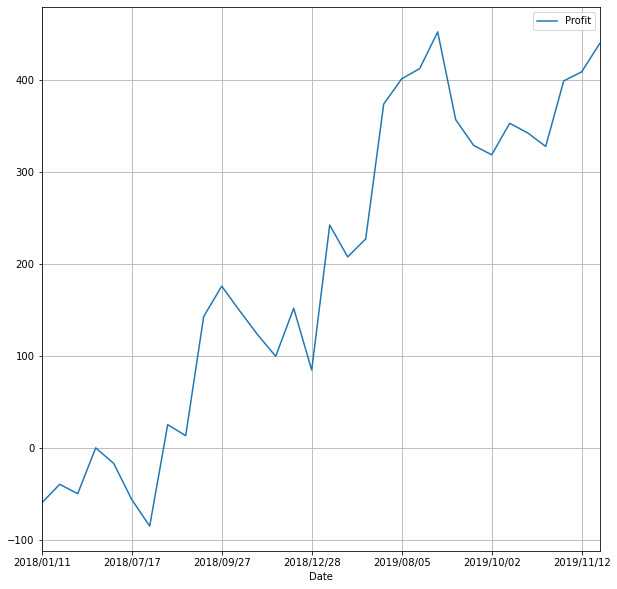

In [127]:
import os

path_comprado = "trade_comprado.txt"
path_vendido = "trade_vendido.txt"

if os.path.exists(path_comprado):
    os.remove(path_comprado)
if os.path.exists(path_vendido):
    os.remove(path_vendido)

equity_curve = pd.DataFrame(columns=['Date', 'Profit'])

for i in range_len_dfs_corr:
    equity_aux = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 1)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    equity_aux = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 0)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    equity_aux = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 1)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    equity_aux = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i], 0)
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    
equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
equity_curve

fig, equity_ax = plt.subplots()

equity_curve.plot(figsize=(10,10), xlim=[0, len(equity_curve) - 1], grid=True, ax=equity_ax)

In [128]:

indicators_dfs[2]


,Means - BBAS3.SA start at 2018/01/02 unitl 2018/12/19\nENBR3.SA start at 2018/01/03 unitl 2018/12/20,Deviations - BBAS3.SA start at 2018/01/02 unitl 2018/12/19\nENBR3.SA start at 2018/01/03 unitl 2018/12/20,Means - ENBR3.SA start at 2018/01/02 unitl 2018/12/19\nBBAS3.SA start at 2018/01/03 unitl 2018/12/20,Deviations - ENBR3.SA start at 2018/01/02 unitl 2018/12/19\nBBAS3.SA start at 2018/01/03 unitl 2018/12/20
0,-0.328374,0.295050,0.057577,0.269980
1,-0.305702,0.292716,0.076302,0.300358
2,-0.257290,0.348147,0.126418,0.364533
3,-0.194750,0.408315,0.186729,0.422765
4,-0.125667,0.464827,0.261437,0.449800
...,...,...,...,...
236,0.738374,0.112243,0.594002,0.187344
237,0.703120,0.168987,0.583802,0.178975
238,0.652153,0.168845,0.611016,0.171402
239,0.627352,0.169831,0.610520,0.171130
